muon_num2_mask [False, False, False, False, False, True, ..., False, True, True, True, True]
first muon cleaned [[285]]


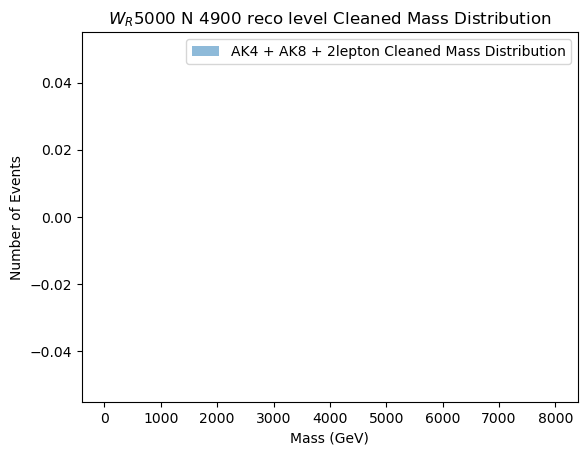

1


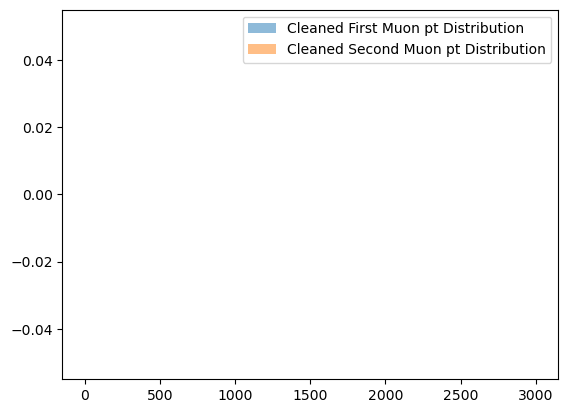

mll [[]]


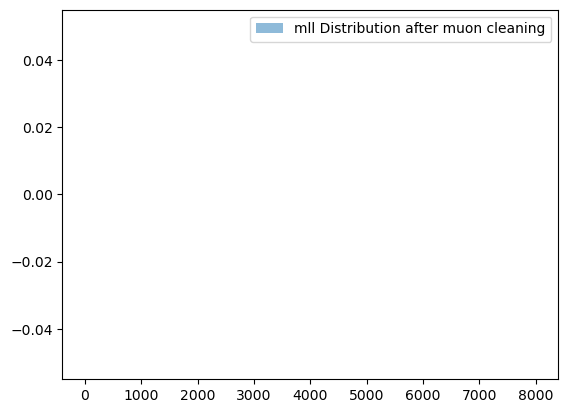

In [5]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()
## main back  = ttH , ttZ , ttW , ttbar , tzj

#sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
#sample = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
#sample = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"
#sample = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
#sample = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"
#sample = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root" # ttz->mu

file = uproot.open(sample)
events = file["Events"]

keys = events.keys()

btag = events["Jet_btagPNetB"].array()
def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]
def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]
def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]

def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btag[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")

btagging = events["FatJet_btagDeepB"].array()
toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
softdrop_mass = events["FatJet_msoftdrop"].array()

closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_ak8jet = find_closest_jet(gentop, fatjets)
#notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################



muon_num2_mask = ak.num(reco_muons["pt"]) > 1
print("muon_num2_mask",muon_num2_mask)

first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온

topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

### ak4 중에서 렙톤 근처에 없고 근처에 ak4없는것 중에 제일 큰 pt
signalb_cleaned = overlap_removal(ak4, [reco_muons, ak4], cut=0.4)
btaggedb_cleaned = btag4_overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, ak4], cut=0.4)


sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
signalb_cleaend_sorted = signalb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

sorted_btaggedb_cleaned = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택


btagging = sorted_btaggedb_cleaned > 0.5
signalb_cleaend_sorted = signalb_cleaend_sorted[btagging]
sortidx = ak.argsort(-signalb_cleaend_sorted["pt"], axis=1)  # pt 기준으로 내림차순 정렬
leading_tagged_bjet = signalb_cleaend_sorted[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택


closest_bjet = find_closest_jet(lhe_bottom, ak4)

toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned,leading_tagged_bjet, fatjets], cut=0.8)
softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)


#sortidx8 = ak.argsort(-signaltop_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
#signaltop_cleaned_sorted = signaltop_cleaned[sortidx8][:, 0:1]
sortidx8 = ak.argsort(-signaltop_cleaned["pt"], axis=1)

toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)  # SoftDrop mass threshold

total_top_mask = toptagging_mask & softdrop_mass_mask

cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

closest_ak8jet = find_closest_jet(gentop, fatjets)



### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signalb_cleaned_pt = ak.sum(leading_tagged_bjet["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)

first_muon_cleaned_eta = ak.sum(first_muon_cleaned["eta"], axis=1)
second_muon_cleaned_eta = ak.sum(second_muon_cleaned["eta"], axis=1)
firstsorted_toptagged_ak8_eta = ak.sum(leading_toptagged_ak8["eta"], axis=1)
firstsorted_bjet_ak8_eta = ak.sum(leading_tagged_bjet["eta"], axis=1)

leftmask = (first_muon_cleaned_pt > 60.0) & (second_muon_cleaned_pt > 53.0) & (signalb_cleaned_pt > 0.0) & (signaltop_cleaned_pt > 0.0) & (abs(first_muon_cleaned_eta) < 2.4) & (abs(second_muon_cleaned_eta) < 2.4)
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signalb_cleaend_sorted = leading_tagged_bjet[leftmask]
signaltop_cleaned_sorted = leading_toptagged_ak8[leftmask]
print("first muon cleaned", first_muon_cleaned["pt"])
mll = (first_muon_cleaned + second_muon_cleaned).mass
mll_mask = mll > 200.0
first_muon_cleaned = first_muon_cleaned[mll_mask]
second_muon_cleaned = second_muon_cleaned[mll_mask]
signalb_cleaend_sorted = signalb_cleaend_sorted[mll_mask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[mll_mask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted
mN = (first_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted).mass
first_muon_cleaned_pt = ak.flatten(first_muon_cleaned["pt"])
second_muon_cleaned_pt = ak.flatten(second_muon_cleaned["pt"])
mll = (first_muon_cleaned + second_muon_cleaned).mass




plt.hist(ak.flatten(combined_p4.mass), bins=80, range=(0, 8000), alpha=0.5, label='AK4 + AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()
mN = (first_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted).mass
#plt.hist(mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.show()
print(len(combined_p4.mass))
#lhe_combined_p4 = n_mother_muon + wr_mother_muon + lhe_bottom + gentop


##lepton pt
plt.hist(ak.flatten(first_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(second_muon_cleaned["pt"]), bins=100, range =(0, 3000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()

##
plt.show()

mll = (first_muon_cleaned + second_muon_cleaned).mass
print("mll", mll)
plt.hist(mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()


In [40]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()


btag = events["Jet_btagPNetB"].array()

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    softdrop_mass = events["FatJet_msoftdrop"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    btagging = events["FatJet_btagDeepB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]

def ak8ak4(sample):
    file = uproot.open(sample)
    events = file["Events"]

    keys = events.keys()
    # LHE-level
    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt     = events["LHEPart_pt"].array()
    lhe_eta    = events["LHEPart_eta"].array()
    lhe_phi    = events["LHEPart_phi"].array()
    lhe_mass   = events["LHEPart_mass"].array()

    bottom_mask   = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

    lhe_particle = ak.zip({
        "pt":   lhe_pt,
        "eta":  lhe_eta,
        "phi":  lhe_phi,
        "mass": lhe_mass
    }, with_name="Momentum4D")

    lhe_bottoms      = lhe_particle[bottom_mask]
    lhe_bottoms_eta  = lhe_bottoms["eta"][:, 1:2]
    lhe_bottoms_phi  = lhe_bottoms["phi"][:, 1:2]
    lhe_bottoms_pt   = lhe_bottoms["pt"][:, 1:2]
    lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]

    lhe_bottom2_eta  = lhe_bottoms["eta"][:, 0:1]
    lhe_bottom2_phi  = lhe_bottoms["phi"][:, 0:1]
    lhe_bottom2_pt   = lhe_bottoms["pt"][:, 0:1]
    lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]

    lhe_bottom = ak.zip({
        "pt":   lhe_bottoms_pt,
        "eta":  lhe_bottoms_eta,
        "phi":  lhe_bottoms_phi,
        "mass": lhe_bottoms_mass
    }, with_name="Momentum4D")

    lhe_bottom2 = ak.zip({
        "pt":   lhe_bottom2_pt,
        "eta":  lhe_bottom2_eta,
        "phi":  lhe_bottom2_phi,
        "mass": lhe_bottom2_mass
    }, with_name="Momentum4D")

    # LHE muons
    lhe_muons = lhe_particle[lhe_muon_mask]
    n_mother_muon = ak.zip({
        "pt":   lhe_muons["pt"][:, 0:1],
        "eta":  lhe_muons["eta"][:, 0:1],
        "phi":  lhe_muons["phi"][:, 0:1],
        "mass": lhe_muons["mass"][:, 0:1]
    }, with_name="Momentum4D")
    wr_mother_muon = ak.zip({
        "pt":   lhe_muons["pt"][:, 1:2],
        "eta":  lhe_muons["eta"][:, 1:2],
        "phi":  lhe_muons["phi"][:, 1:2],
        "mass": lhe_muons["mass"][:, 1:2]
    }, with_name="Momentum4D")

    # Gen-level top
    gen_pids   = events["GenPart_pdgId"].array()
    genparticle = ak.zip({
        "pt":   events["GenPart_pt"].array(),
        "eta":  events["GenPart_eta"].array(),
        "phi":  events["GenPart_phi"].array(),
        "mass": events["GenPart_mass"].array()
    }, with_name="Momentum4D")
    gentops = genparticle[(gen_pids == 6) | (gen_pids == -6)]
    gentop = ak.zip({
        "pt":   gentops["pt"][:, 0:1],
        "eta":  gentops["eta"][:, 0:1],
        "phi":  gentops["phi"][:, 0:1],
        "mass": gentops["mass"][:, 0:1]
    }, with_name="Momentum4D")

    # Reco-level
    ak4_eta = events["Jet_eta"].array()
    ak4_phi = events["Jet_phi"].array()
    ak4_pt = events["Jet_pt"].array()
    ak4_flavor = events["Jet_hadronFlavour"].array()
    ak4_mass = events["Jet_mass"].array()
    btag = events["Jet_btagPNetB"].array()

    ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
        }, with_name = "Momentum4D")
    
    fatjets = ak.zip({
        "pt":   events["FatJet_pt"].array(),
        "eta":  events["FatJet_eta"].array(),
        "phi":  events["FatJet_phi"].array(),
        "mass": events["FatJet_mass"].array()
    }, with_name="Momentum4D")
    reco_muons = ak.zip({
        "pt":   events["Muon_pt"].array(),
        "eta":  events["Muon_eta"].array(),
        "phi":  events["Muon_phi"].array(),
        "mass": events["Muon_mass"].array()
    }, with_name="Momentum4D")
    btagging = events["FatJet_btagDeepB"].array()
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    softdrop_mass = events["FatJet_msoftdrop"].array()
    btag = events["Jet_btagPNetB"].array()
    # Clean b-jet
    
    first_muon     = reco_muons[:, 0:1]
    second_muon    = reco_muons[:, 1:2]

    first_muon_cleaned  = overlap_removal(first_muon, [reco_muons], cut=0.4)
    second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

    signalb_cleaned = overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, ak4], cut=0.4)
    btaggedb_cleaned = btag4_overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, ak4], cut=0.4)


    sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    signalb_cleaend_sorted = signalb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

    sorted_btaggedb_cleaned = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
    sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택


    btagging = sorted_btaggedb_cleaned > 0.5
    signalb_cleaend_sorted = signalb_cleaend_sorted[btagging]
    sortidx = ak.argsort(-signalb_cleaend_sorted["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    leading_tagged_bjet = signalb_cleaend_sorted[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

    # Clean top-jet
    toptag_scores    = toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)
    softdrop_masses  = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned], cut=0.8)
    signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned, leading_tagged_bjet, fatjets], cut=0.8)
    mask_top         = (toptag_scores > 0.9) & (softdrop_masses > 120) & (softdrop_masses < 250)
    top_jets         = signaltop_cleaned[mask_top]
    leading_toptag_ak8 = top_jets[ak.argsort(-top_jets["pt"], axis=1)][:, 0:1]

    # Event-level mask
    pt1 = ak.sum(first_muon_cleaned["pt"], axis=1)
    pt2 = ak.sum(second_muon_cleaned["pt"], axis=1)
    ptb = ak.sum(leading_tagged_bjet["pt"], axis=1)
    ptt = ak.sum(leading_toptag_ak8["pt"], axis=1)
    eta1 =ak.sum(first_muon_cleaned["eta"], axis=1)
    eta2 = ak.sum(second_muon_cleaned["eta"], axis=1)
    evt_mask = (
        (pt1 > 60) & (pt2 > 53) &
        (ptb > 0) & (ptt > 0) &
        (abs(eta1) < 2.4) & (abs(eta2) < 2.4)
    )

    fm1 = first_muon_cleaned[evt_mask]
    fm2 = second_muon_cleaned[evt_mask]
    lb  = leading_tagged_bjet[evt_mask]
    lt  = leading_toptag_ak8[evt_mask]

    # Dilepton mass cut
    mll = (fm1 + fm2).mass
    mll_mask = mll > 200
    fm1 = fm1[mll_mask]
    fm2 = fm2[mll_mask]
    lb  = lb[mll_mask]
    lt  = lt[mll_mask]

    # Final vars
    combined_p4   = (fm1 + fm2 + lb + lt).mass
    mN            = (fm1 + lb + lt).mass
    mu1_pt_flat   = ak.flatten(fm1["pt"])
    mu2_pt_flat   = ak.flatten(fm2["pt"])
    mll_flat      = ak.flatten(mll)

    return combined_p4, mN, mu1_pt_flat, mu2_pt_flat, mll_flat

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  1.,  0.,  3.,
         3.,  1.,  3.,  4., 10.,  5.,  4.,  6.,  3.,  2.,  0.,  3.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([   0.,  160.,  320.,  480.,  640.,  800.,  960., 1120., 1280.,
        1440., 1600., 1760., 1920., 2080., 2240., 2400., 2560., 2720.,
        2880., 3040., 3200., 3360., 3520., 3680., 3840., 4000., 4160.,
        4320., 4480., 4640., 4800., 4960., 5120., 5280., 5440., 5600.,
        5760., 5920., 6080., 6240., 6400., 6560., 6720., 6880., 7040.,
        7200., 7360., 7520., 7680., 7840., 8000.]),
 <BarContainer object of 50 artists>)

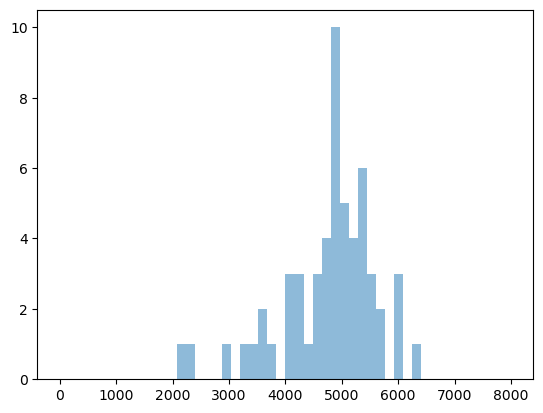

In [ ]:
## main back  = ttH , ttZ , ttW , ttbar , tzj

signal5049 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
signal5025 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"

## TW ( hadronic W )
twm_2l2nu = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
twp_2l2nu = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tw_lnu2q = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"

## TZJ

## TTH
tth_mumu = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tth_zz = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"

## TTZ
ttz_mumu = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root "

## TTW





combined_p4, mN, mu1_pt, mu2_pt, mll = ak4ak8(signal)
plt.hist(ak.flatten(combined_p4), bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')

In [ ]:
plt.hist(all_mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.legend()
plt.show()
plt.hist(all_deltaR, bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()
plt.show()
plt.hist(all_final_muon1_pt, bins=100, range=(0, 8000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(all_final_muon2_pt, bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
plt.hist(all_mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()
plt.scatter(all_final_muon1_pt, all_mll, alpha=0.5, label='First Muon pt vs mll')
plt.scatter(all_final_muon2_pt, all_mll, alpha=0.5, label='Second Muon pt vs mll')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.legend()
plt.show()
plt.scatter(all_final_toptagged_ak8_pt, all_final_bjet_ak8_pt, alpha=0.5, label='Leading Top Tagged AK8 Jet pt vs Leading B Tagged AK8 Jet pt')
plt.legend()
plt.show()